In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

mpl.rcParams['font.size'] = 12
mpl.rcParams['font.family'] = 'Arial'   # if using Linux, this might cause warnings


In [19]:
# functions
def read_msa_fasta(file_name):
    """
    Read a multiple sequence alignment from a FASTA file.

    Args:
        file_name (str): the name of the FASTA file
    
    Returns:
        list: a list of sequences
    """

    sequences = []
    labels = []

    # read fasta file
    with open(file_name) as f:
        for line in f:
            if line.startswith('>'):
                labels.append(line[1:].strip())
                continue
            sequence = line.strip()
            # check sequence correctness
            if not all([aa in 'ACDEFGHIKLMNPQRSTVWY' for aa in sequence]):
                raise ValueError('Invalid amino acid sequence!')
            sequences.append(sequence)

    # check aligned
    length = len(sequences[0])
    for seq in sequences:
        if len(seq) != length:
            raise ValueError('Sequences are not aligned!')

    return np.array(sequences, dtype=str), np.array(labels, dtype=str)


def sequences_to_categories_matrix(sequences):
    """
    Convert a list of sequences to a matrix of categories.

    Args:
        sequences (list): a list of sequences
    
    Returns:
        numpy.ndarray: a matrix of categories
    """

    categories = np.zeros((len(sequences), len(sequences[0])), dtype=int)
    for i, seq in enumerate(sequences):
        for j, aa in enumerate(seq):
            categories[i, j] = aa_to_categories[aa]
    
    return categories


# Dictionaries
BLOSUM62 = {
    'AA': 4, 'AR': -1, 'AN': -2, 'AD': -2, 'AC': 0, 'AQ': -1, 'AE': -1, 'AG': 0, 'AH': -2, 'AI': -1, 'AL': -1, 'AK': -1, 'AM': -1, 'AF': -2, 'AP': -1, 'AS': 1, 'AT': 0, 'AW': -3, 'AY': -2, 'AV': 0, 'A-': -4,
    'RA': -1, 'RR': 5, 'RN': 0, 'RD': -2, 'RC': -3, 'RQ': 1, 'RE': 0, 'RG': -2, 'RH': 0, 'RI': -3, 'RL': -2, 'RK': 2, 'RM': -1, 'RF': -3, 'RP': -2, 'RS': -1, 'RT': -1, 'RW': -3, 'RY': -2, 'RV': -3, 'R-': -4,
    'NA': -2, 'NR': 0, 'NN': 6, 'ND': 1, 'NC': -3, 'NQ': 0, 'NE': 0, 'NG': 0, 'NH': 1, 'NI': -3, 'NL': -3, 'NK': 0, 'NM': -2, 'NF': -3, 'NP': -2, 'NS': 1, 'NT': 0, 'NW': -4, 'NY': -2, 'NV': -3, 'N-': -4,
    'DA': -2, 'DR': -2, 'DN': 1, 'DD': 6, 'DC': -3, 'DQ': 0, 'DE': 2, 'DG': -1, 'DH': -1, 'DI': -3, 'DL': -4, 'DK': -1, 'DM': -3, 'DF': -3, 'DP': -1, 'DS': 0, 'DT': -1, 'DW': -4, 'DY': -3, 'DV': -3, 'D-': -4,
    'CA': 0, 'CR': -3, 'CN': -3, 'CD': -3, 'CC': 9, 'CQ': -3, 'CE': -4, 'CG': -3, 'CH': -3, 'CI': -1, 'CL': -1, 'CK': -3, 'CM': -1, 'CF': -2, 'CP': -3, 'CS': -1, 'CT': -1, 'CW': -2, 'CY': -2, 'CV': -1, 'C-': -4,
    'QA': -1, 'QR': 1, 'QN': 0, 'QD': 0, 'QC': -3, 'QQ': 5, 'QE': 2, 'QG': -2, 'QH': 0, 'QI': -3, 'QL': -2, 'QK': 1, 'QM': 0, 'QF': -3, 'QP': -1, 'QS': 0, 'QT': -1, 'QW': -2, 'QY': -1, 'QV': -2, 'Q-': -4,
    'EA': -1, 'ER': 0, 'EN': 0, 'ED': 2, 'EC': -4, 'EQ': 2, 'EE': 5, 'EG': -2, 'EH': 0, 'EI': -3, 'EL': -3, 'EK': 1, 'EM': -2, 'EF': -3, 'EP': -1, 'ES': 0, 'ET': -1, 'EW': -3, 'EY': -2, 'EV': -2, 'E-': -4,
    'GA': 0, 'GR': -2, 'GN': 0, 'GD': -1, 'GC': -3, 'GQ': -2, 'GE': -2, 'GG': 6, 'GH': -2, 'GI': -4, 'GL': -4, 'GK': -2, 'GM': -3, 'GF': -3, 'GP': -2, 'GS': 0, 'GT': -2, 'GW': -2, 'GY': -3, 'GV': -3, 'G-': -4,
    'HA': -2, 'HR': 0, 'HN': 1, 'HD': -1, 'HC': -3, 'HQ': 0, 'HE': 0, 'HG': -2, 'HH': 8, 'HI': -3, 'HL': -3, 'HK': -1, 'HM': -2, 'HF': -1, 'HP': -2, 'HS': -1, 'HT': -2, 'HW': -2, 'HY': 2, 'HV': -3, 'H-': -4,
    'IA': -1, 'IR': -3, 'IN': -3, 'ID': -3, 'IC': -1, 'IQ': -3, 'IE': -3, 'IG': -4, 'IH': -3, 'II': 4, 'IL': 2, 'IK': -3, 'IM': 1, 'IF': 0, 'IP': -3, 'IS': -2, 'IT': -1, 'IW': -3, 'IY': -1, 'IV': 3, 'I-': -4,
    'LA': -1, 'LR': -2, 'LN': -3, 'LD': -4, 'LC': -1, 'LQ': -2, 'LE': -3, 'LG': -4, 'LH': -3, 'LI': 2, 'LL': 4, 'LK': -2, 'LM': 2, 'LF': 0, 'LP': -3, 'LS': -2, 'LT': -1, 'LW': -2, 'LY': -1, 'LV': 1, 'L-': -4,
    'KA': -1, 'KR': 2, 'KN': 0, 'KD': -1, 'KC': -3, 'KQ': 1, 'KE': 1, 'KG': -2, 'KH': -1, 'KI': -3, 'KL': -2, 'KK': 5, 'KM': -1, 'KF': -3, 'KP': -1, 'KS': 0, 'KT': -1, 'KW': -3, 'KY': -2, 'KV': -2, 'K-': -4,
    'MA': -1, 'MR': -1, 'MN': -2, 'MD': -3, 'MC': -1, 'MQ': 0, 'ME': -2, 'MG': -3, 'MH': -2, 'MI': 1, 'ML': 2, 'MK': -1, 'MM': 5, 'MF': 0, 'MP': -2, 'MS': -1, 'MT': -1, 'MW': -1, 'MY': -1, 'MV': 1, 'M-': -4,
    'FA': -2, 'FR': -3, 'FN': -3, 'FD': -3, 'FC': -2, 'FQ': -3, 'FE': -3, 'FG': -3, 'FH': -1, 'FI': 0, 'FL': 0, 'FK': -3, 'FM': 0, 'FF': 6, 'FP': -4, 'FS': -2, 'FT': -2, 'FW': 1, 'FY': 3, 'FV': -1, 'F-': -4,
    'PA': -1, 'PR': -2, 'PN': -2, 'PD': -1, 'PC': -3, 'PQ': -1, 'PE': -1, 'PG': -2, 'PH': -2, 'PI': -3, 'PL': -3, 'PK': -1, 'PM': -2, 'PF': -4, 'PP': 7, 'PS': -1, 'PT': -1, 'PW': -4, 'PY': -3, 'PV': -2, 'P-': -4,
    'SA': 1, 'SR': -1, 'SN': 1, 'SD': 0, 'SC': -1, 'SQ': 0, 'SE': 0, 'SG': 0, 'SH': -1, 'SI': -2, 'SL': -2, 'SK': 0, 'SM': -1, 'SF': -2, 'SP': -1, 'SS': 4, 'ST': 1, 'SW': -3, 'SY': -2, 'SV': -2, 'S-': -4,
    'TA': 0, 'TR': -1, 'TN': 0, 'TD': -1, 'TC': -1, 'TQ': -1, 'TE': -1, 'TG': -2, 'TH': -2, 'TI': -1, 'TL': -1, 'TK': -1, 'TM': -1, 'TF': -2, 'TP': -1, 'TS': 1, 'TT': 5, 'TW': -2, 'TY': -2, 'TV': 0, 'T-': -4,
    'WA': -3, 'WR': -3, 'WN': -4, 'WD': -4, 'WC': -2, 'WQ': -2, 'WE': -3, 'WG': -2, 'WH': -2, 'WI': -3, 'WL': -2, 'WK': -3, 'WM': -1, 'WF': 1, 'WP': -4, 'WS': -3, 'WT': -2, 'WW': 11, 'WY': 2, 'WV': -3, 'W-': -4,
    'YA': -2, 'YR': -2, 'YN': -2, 'YD': -3, 'YC': -2, 'YQ': -1, 'YE': -2, 'YG': -3, 'YH': 2, 'YI': -1, 'YL': -1, 'YK': -2, 'YM': -1, 'YF': 3, 'YP': -3, 'YS': -2, 'YT': -2, 'YW': 2, 'YY': 7, 'YV': -1, 'Y-': -4,
    'VA': 0, 'VR': -3, 'VN': -3, 'VD': -3, 'VC': -1, 'VQ': -2, 'VE': -2, 'VG': -3, 'VH': -3, 'VI': 3, 'VL': 1, 'VK': -2, 'VM': 1, 'VF': -1, 'VP': -2, 'VS': -2, 'VT': 0, 'VW': -3, 'VY': -1, 'VV': 4, 'V-': -4,
    '-A': -4, '-R': -4, '-N': -4, '-D': -4, '-C': -4, '-Q': -4, '-E': -4, '-G': -4, '-H': -4, '-I': -4, '-L': -4, '-K': -4, '-M': -4, '-F': -4, '-P': -4, '-S': -4, '-T': -4, '-W': -4, '-Y': -4, '-V': -4, '--': 0
}

aa_to_categories = {
    'A': 0,     # hydrophobic
    'C': 0,     # hydrophobic
    'D': 3,     # acid
    'E': 3,     # acid
    'F': 0,     # hydrophobic
    'G': 1,     # glycine
    'H': 4,     # base
    'I': 0,     # hydrophobic
    'K': 4,     # base
    'L': 0,     # hydrophobic
    'M': 0,     # hydrophobic
    'N': 5,     # amide
    'P': 1,     # glycine
    'Q': 5,     # amide
    'R': 4,     # base
    'S': 2,     # hydroxyl
    'T': 2,     # hydroxyl
    'V': 0,     # hydrophobic
    'W': 0,     # hydrophobic
    'Y': 2,     # hydroxyl
}

categories_to_color = {
    0: '#F6FA70',   # yellow for hydrophobic
    1: '#F6FA70',   # yellow for glycine
    2: '#00DFA2',   # green for hydroxyl
    3: '#FF0060',   # red for acid
    4: '#0079FF',   # blue for base
    5: '#F6FA70',   # yellow for amide
}

# create a colormap
msa_cmap = mpl.colors.ListedColormap([categories_to_color[i] for i in range(len(categories_to_color))])


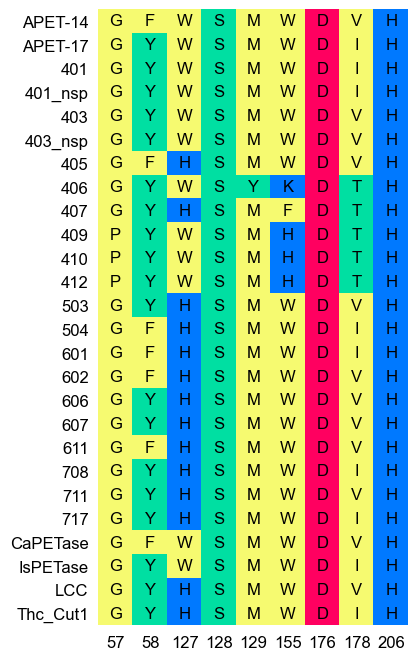

In [20]:
sequences, labels = read_msa_fasta('example.fasta')
categories = sequences_to_categories_matrix(sequences)


plt.figure(figsize=(4,8))
plt.imshow(categories, cmap=msa_cmap, aspect='auto', vmin=0, vmax=len(categories_to_color)-1)

# write sequence label
for i in range(len(sequences)):
    for j in range(len(sequences[i])):
        plt.text(j, i, sequences[i][j], ha='center', va='center', color='black')


# ticks
plt.yticks(np.arange(len(labels)),labels)
plt.xticks(np.arange(len(sequences[0])),[57,58,127,128,129,155,176,178,206])

plt.box(False)
plt.tick_params(
    axis='both',          # Apply to both x and y axes
    which='both',         # Apply to both major and minor ticks
    bottom=False,         # Turn off ticks on the bottom edge
    top=False,            # Turn off ticks on the top edge
    left=False,           # Turn off ticks on the left edge
    right=False,          # Turn off ticks on the right edge
    labelbottom=True,     # Keep the labels on the bottom
    labelleft=True        # Keep the labels on the left
)

plt.savefig('example.png', dpi=300, bbox_inches='tight')
plt.show()

In [43]:
# calculate distance matrix using BLOSUM62
distance_matrix = np.zeros((len(sequences), len(sequences)))
for i in range(len(sequences)):
    for j in range(i+1, len(sequences)):
        blosum62_score = 0
        for k in range(len(sequences[i])):
            blosum62_score += BLOSUM62[sequences[i][k]+sequences[j][k]]
        distance_matrix[i, j] = -blosum62_score
        distance_matrix[j, i] = -blosum62_score

distance_matrix -= np.min(distance_matrix) -1
np.fill_diagonal(distance_matrix, 0)

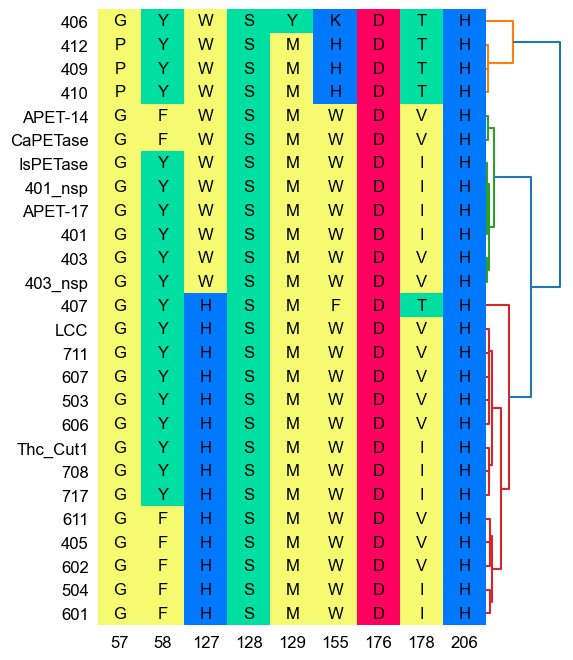

In [47]:
sequences, labels = read_msa_fasta('example.fasta')
categories = sequences_to_categories_matrix(sequences)


plt.figure(figsize=(6,8))

n_col=6


plt.subplot2grid((1, n_col), (0, n_col-1))
# create a dendrogram
linkage_matrix = linkage(squareform(distance_matrix), method='ward')
tree_dict = dendrogram(linkage_matrix, color_threshold=40, labels=labels, orientation='right')

# reverse y axis
plt.gca().invert_yaxis()
plt.box(False)
plt.xticks([])
plt.yticks([])




plt.subplot2grid((1, n_col), (0, 0), colspan=n_col-1)
plt.imshow(categories[tree_dict["leaves"],:], cmap=msa_cmap, aspect='auto', vmin=0, vmax=len(categories_to_color)-1)

# write sequence label
for i in range(len(sequences)):
    for j in range(len(sequences[i])):
        plt.text(j, i, sequences[tree_dict["leaves"]][i][j], ha='center', va='center', color='black')


# ticks
plt.yticks(np.arange(len(labels)),labels[tree_dict["leaves"]])
plt.xticks(np.arange(len(sequences[0])),[57,58,127,128,129,155,176,178,206])

plt.box(False)
plt.tick_params(
    axis='both',          # Apply to both x and y axes
    which='both',         # Apply to both major and minor ticks
    bottom=False,         # Turn off ticks on the bottom edge
    top=False,            # Turn off ticks on the top edge
    left=False,           # Turn off ticks on the left edge
    right=False,          # Turn off ticks on the right edge
    labelbottom=True,     # Keep the labels on the bottom
    labelleft=True        # Keep the labels on the left
)



# set gap between figures
plt.subplots_adjust(wspace=0)

plt.savefig('example.png', dpi=300, bbox_inches='tight')
plt.show()